In [40]:
%config Completer.use_jedi = False #for auto complete code

In [104]:
from scipy.interpolate import griddata
from osgeo import osr
from osgeo import gdal
from osgeo import gdal_array
import rasterio
from rasterio.transform import from_origin
import geopandas as gpd

from shapely.geometry import mapping
from shapely.geometry import Polygon, Point, MultiLineString
from collections import OrderedDict
import pandas as pd
import numpy as np

#plots
import matplotlib.pyplot as plt

#modflow
import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils.gridintersect import GridIntersect
import flopy.utils.binaryfile as bf

import os, json

import mplleaflet

import sys
sys.path.insert(0, 'd:/Proyectos_GitHub/dev_mode/src')
from meshProperties import mesh_shape
#Create mesh object
vorMesh = createVoronoi()

#Define base refinement and refinement levels
vorMesh.defineParameters(maxRef = 400, minRef=50, stages=5)


/--------Sumary of cell discretization-------/
Maximun refinement: 400.00 m.
Minimum refinement: 50.00 m.
Cell size list: [400.  312.5 225.  137.5  50. ] m.
/--------------------------------------------/



In [18]:
#Open limit layers and refinement definition layers
vorMesh.addLimit('basin','../examples/In/shp/Geospatial_model/ModelLimit1.shp')
vorMesh.addLayer('facilities','../examples/In/shp/Geospatial_model/ModelWell2.shp')
vorMesh.addLayer('facilities','../examples/In/shp/Geospatial_model/ModelRiver2.shp')

In [19]:
#Generate point pair array
vorMesh.extractOrgVertices()

#Generate the point cloud and voronoi
vorMesh.createPointCloud()
vorMesh.generateVoronoi()

#check or create an output folder
outPath = '../examples/out/geospacial'
if os.path.isdir(outPath):
    print('The output folder %s exists'%outPath)
else:
    os.mkdir(outPath)
    print('The output folder %s has been generated.'%outPath)

#Export point data and voronoi polygons
#Points
vorMesh.getPointsAsShp('vertexOrg',outPath+'/vertexOrg.shp')
vorMesh.getPointsAsShp('vertexDist',outPath+'/vertexDist.shp')
vorMesh.getPointsAsShp('vertexBuffer',outPath+'/vertexBuffer.shp')
vorMesh.getPointsAsShp('vertexMaxRef',outPath+'/vertexMaxRef.shp')
vorMesh.getPointsAsShp('vertexMinRef',outPath+'/vertexMinRef.shp')
vorMesh.getPointsAsShp('vertexTotal',outPath+'/vertexTotal.shp')
#Polygons

vorMesh.getPolyAsShp('voronoiRegions',outPath+'/voronoiRegions.shp')


/----Sumary of points for voronoi meshing----/
Distributed points from layers: 136
Points from layer buffers: 275
Points from max refinement areas: 22
Points from min refinement areas: 51
Total points inside the limit: 455
/--------------------------------------------/

Time required for point generation: 0.13 seconds 

The output folder ../examples/out/geospacial exists


# DISV

In [22]:
mesh=mesh_shape('../examples/out/geospacial/voronoiRegions.shp')
gridprops=mesh.get_gridprops_disv()

100%|██████████████████████████████████████████████████████████████████████████████| 455/455 [00:00<00:00, 3790.82it/s]


Creating a unique list of vertices [[x1,y1],[x2,y2],...]

Extracting cell2d data and grid index


In [23]:
cell2d = gridprops['cell2d']
vertices = gridprops['vertices']
ncpl = gridprops['ncpl']
nvert = gridprops['nvert']
centroids=gridprops['centroids']

# Geometria del Acuifero

In [72]:
#Extact dem values for each centroid of the voronois
src = rasterio.open('../examples/in/rst/ModeloDem1.tif')
elevation=[x for x in src.sample(centroids)]

nlay = 3

mtop=np.array([elev[0] for i,elev in enumerate(elevation)])

zbot=np.zeros((nlay,ncpl))

AcuifInf_Bottom = -120

AcuifMed_Bottom = AcuifInf_Bottom + (0.5 * (mtop - AcuifInf_Bottom))

AcuifSup_Bottom = AcuifInf_Bottom + (0.75 * (mtop - AcuifInf_Bottom))


zbot[0,] = AcuifSup_Bottom 
zbot[1,] = AcuifMed_Bottom
zbot[2,] = AcuifInf_Bottom


# Creación del modelo Modflow 6

In [73]:
# create simulation
model_name = 'geo_model'
model_ws = '../examples/out/geospacial/model'
exe_name = '../exe/mf6.exe'

sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name,sim_ws=model_ws)

In [74]:
# create tdis package
tdis_rc = [(200 * 86400.0, 1, 1.0)]
nper=len(tdis_rc)
tdis = flopy.mf6.ModflowTdis(sim, nper=nper, time_units='seconds',perioddata=tdis_rc)

In [75]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, linear_acceleration='BICGSTAB')

In [76]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True, newtonoptions=['under_relaxation'])

In [77]:
# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl,top=mtop, botm=botm,nvert=nvert, vertices=vertices,cell2d=cell2d)

In [58]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=np.stack([mtop for i in range(nlay)]))

In [63]:
Kx =[1E-5,5E-4,2E-4]
icelltype = [1,1,0]
npf = flopy.mf6.ModflowGwfnpf(gwf,save_specific_discharge=True,icelltype=icelltype,k=Kx)

In [67]:
sto=flopy.mf6.ModflowGwfsto(gwf,ss=1e-05, sy=0.15)

In [88]:
evtr = 1.2/365/86400
evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=mtop,rate=evtr,depth=1.0)

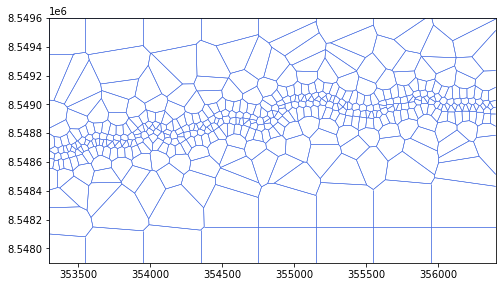

In [54]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=gwf)
linecollection = modelmap.plot_grid(linewidth=0.5, color='royalblue')

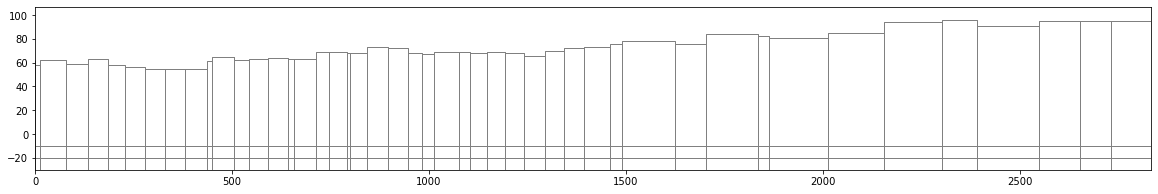

In [83]:
line = np.array([(353316.856,8548810.747), (356378.853,8548789.870)])

fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": line})
linecollection = modelxsect.plot_grid()

## Para insertar las condiciones de recarga se realiza una interceptacion entre el shp de la zona de recarga y la grilla, de esta manera se optiene los indices de las celdas que conforman dicha zona

In [90]:
tgr = fgrid.VertexGrid(vertices, cell2d)
ix2 = GridIntersect(tgr)

C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\flopy\utils\gridintersect.py:337: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = icell


In [97]:
zone1=gpd.read_file('../examples/In/shp/Geospatial_model/ModelRechargeZone1.shp')
result=ix2.intersect(zone1['geometry'].loc[0])

C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\descartes\patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


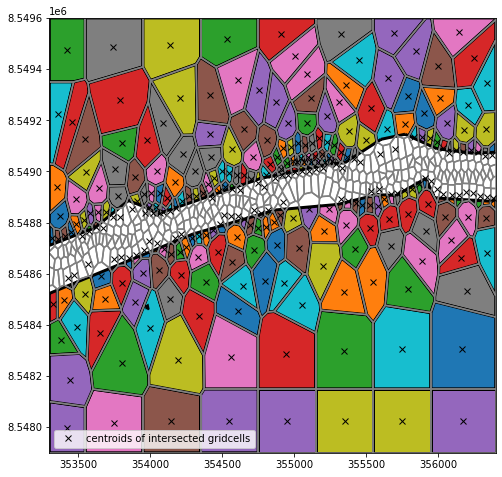

In [106]:
# install descartes 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix2.plot_polygon(result, ax=ax, lw=3)

for cellid in result.cellids:
    (h2,) = ax.plot(
        tgr.xcellcenters[cellid],
        tgr.ycellcenters[cellid],
        "kx",
        label="centroids of intersected gridcells",
    )

ax.legend([h2], [i.get_label() for i in [h2]], loc="best");